In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dropout
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad, Adadelta, Adamax, Nadam, Optimizer
import matplotlib.pyplot as plt
from typing import List, Union
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline

# Exploring our Data

****

In [2]:
data_folder = os.path.join(os.getcwd(), 'Data', 'Kaggle MNIST Digits')

Listing the contents of the folder:

In [3]:
print(os.listdir(data_folder))

['test.csv', 'train.csv', 'sample_submission.csv']


In [4]:
train_data = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test_data = pd.read_csv(os.path.join(data_folder, 'test.csv'))
print("Training data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Training data shape:  (42000, 785)
Test data shape:  (28000, 784)


In [5]:
display(train_data.head())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our training data consists of 784 feature columns and a "label" column. The granularity of our data is an image classification. This classification is in the form of 784 "pixel" columns that contain a value between 0-255. These numeric values represent the pixel intensity within each grid squrae contained in a 28x28 grid (yielding 784 values per image). The "label" column contains the digit represented by the image, and ranges from 0-9. There are 42,000 different digit classifications in our training data.

In [6]:
display(test_data.head())

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our test data consists of the same 784 feature columns without the label column. Our test data contains the features of 28,000 different images.

For a more visual understanding of how these columns represent digit images, I have displayed the actual digit images of 12 randomly chosen rows using the `.imshow()` function. 

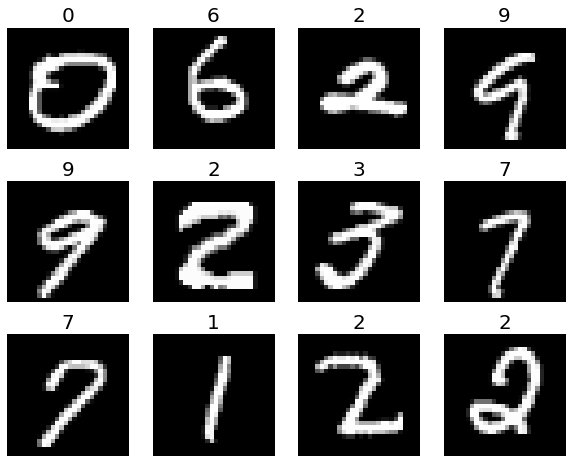

In [7]:
np.random.seed(42)  # For Reproducibility
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes = axes.ravel()
indices = np.random.randint(0, train_data.shape[0], size=12)  # Grab 9 random indices from train data
for i in range(12):
    axes[i].imshow(train_data.drop(columns=['label']).values[indices[i], :].reshape(28, 28), cmap='gray')
    axes[i].axis('off')  # Nobody cares about the axes :(
    label = train_data['label'][indices[i]]  # The actual label for this data
    axes[i].set_title(label, fontsize=20)
plt.show()

Here's another glimpse of what one row of our data looks like, as an image and as an array:

Pictorially:


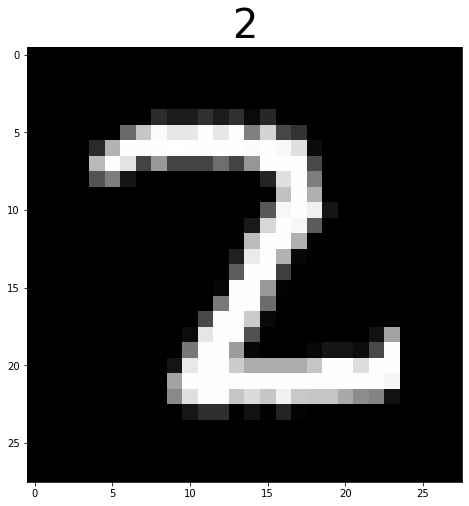

What the computer receives:

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   7  24  24  97 253 253
  253 253 255 180  48   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  30 186 252 252 253 252 252
  252 252 253 252 227  29   0   0   0   0]
 [  0   0   0   0   0   0   0   0  

In [8]:
fig, axes = plt.subplots(1, figsize=(10, 8))
axes.imshow(train_data.drop(columns=['label']).values[indices[10], :].reshape(28, 28), cmap='gray')
axes.set_title(label, fontsize=40)
print("Pictorially:")
plt.show()
print("What the computer receives:")
print()
print(train_data.drop(columns =['label']).values[10, :].reshape(28, 28))

We now get a clear idea of what our data represents. We proceed to normalize and split our data. We also perform One Hot Encoding on our "label" values. 

In [9]:
Y_train = to_categorical(train_data['label'].values, num_classes = 10)
X_train = train_data.drop(columns =['label']).values
X_test = test_data.values

In [10]:
Y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

***
# Creating a Neural Network

We use the TensorFlow and Keras libraries to create a generic function using which we can create our neural network. Our function creates a **Sequential** model by adding the first layer, then the hidden layers, then the output layer, and finally compiling the model using an optimizer, loss function, and evaluation metric. The number of inputs, outputs, sizes and activation functions for each hidden layer, and optimizer are all passed in as arguments of the function. 

As our model only comprises of an input layer, hidden layers, and an output layer, we create an **Artificial Neural Network** with a **feedforward** mechanism. This is because our inputs are only processed in the forward direction.

In [11]:
def create_network(num_inputs: int, 
            num_outputs: int, 
            hidden_layer_sizes: List[int], 
            activations: List[str], 
            optimizer: Optimizer) -> Sequential:
    """
    Creates a complete Neural Network where
        num_inputs: Number of input features exluding the bias
        num_outputs: Number of outputs
        hidden_layer_sizes: A list representing the number of hidden units in each layer
        activations: A list containing which activation to use after each layer
        optimizer: An optimizer to use
    """
    assert len(hidden_layer_sizes) == len(activations), 'activations need to be the same length as hidden_layer_sizes'
    num_layers = len(hidden_layer_sizes) + 1
    model = Sequential(name="{}layerNeuralNetwork".format(num_layers))

    first_layer = True;
    
    # Adding Layers
    for layer in range(len(hidden_layer_sizes)):
        layer_name = 'Layer' + str(layer)
        
        # Adding the first layer
        if first_layer:
            model.add(Dense(hidden_layer_sizes[layer], activation=activations[layer], name='Input', input_shape=(num_inputs,)))
            first_layer = False;

        # Adding Hidden Layers
        else:
            model.add(Dense(hidden_layer_sizes[layer], activation=activations[layer], name=layer_name))
            
    # Add output layer
    model.add(Dense(num_outputs, activation='softmax', name='Output'))
    
    # Compiling the model by specifying the optimzer, loss function, and evaluation metric
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model;    

We use the [**Softmax**](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) activation function in our output layer. This is because we want our output to be in the form of a probability distribution of our input belonging to a given class (with respect to the current set of weights in the neural network). This translates to the probability distribution of an image belonging to 0,1,2,...9. Softmax also works well with backpropagation, which is critical for our neural network to update its weights in order to make better predictions. 

To calculate the crossentropy loss for a training cycle, we use the probability distribution outputted by the Softmax activation function of the output layer. This loss is calculated by a loss function using labels and predictions. In our neural network, as the true output values of our input data (`Y_train`) has been One Hot encoded, the loss function we use is [**CategoricalCrossentropy**](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy). We also make the canonical choice of using the "Accuracy" metric for evaluating our model's performance.

We now proceed to creating our model by specifying the arguments passed in `create_network`.

In [12]:
len(Y_train)

42000

In [13]:
inputs = X_train.shape[1]
outputs = len((Y_train[0]))
optimizer = Adam()
hidden_layer_sizes = [256]
activations = ['relu']

model = create_network(num_inputs = inputs, 
                       num_outputs = outputs, 
                       optimizer=optimizer,
                       hidden_layer_sizes = hidden_layer_sizes, 
                       activations= activations)

We use the [**Adam algorithm**](https://keras.io/api/optimizers/adam/) as our optimizer to control the back propagation process. This is because this algorithm is "computationally efficient, has little memory requirement, (...) and is well suited for problems that are large in terms of data/parameters" according to Kingma et al., 2014.

We also use the **Rectified Linear Unit** (ReLU) as our activation function for the hidden layers as it's more computationally efficient compared to other activation functions such as Sigmoid-like functions. The output of each hidden layer passes through the ReLU activation function that simply returns `max(output, 0)`.

We now proceed to fitting the model we created to our dataset:

In [14]:
seed=0
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=.2, random_state=seed)

In order to quicken the training process, we use a regularization technique called **[Early Stopping](https://keras.io/api/callbacks/early_stopping/)**. What this does is that it monitors the change in the validation set's loss over the training process across the given epochs (number of training cycles). When there is no global improvement in the validation loss of the model over the course of a preset number of training cycles, then the model terminates further training. It then uses the weights assigned in to the network in the training cycle where the lowest global validation loss was achieved.

This regularization technique reduces training time significantly, with a very slight compromise on the accuracy on the training set. In our model, we set the preset number of training cycles where no improvement is seen to equal 10 (≈20% of total epochs).

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights= True)
model.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), 
          callbacks=[callback], verbose=1)


Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 7s 210us/sample - loss: 4.1785 - accuracy: 0.8791 - val_loss: 0.9585 - val_accuracy: 0.9158
Epoch 2/50
33600/33600 [==============================] - 6s 187us/sample - loss: 0.5012 - accuracy: 0.9275 - val_loss: 0.5335 - val_accuracy: 0.9121
Epoch 3/50
33600/33600 [==============================] - 6s 167us/sample - loss: 0.3325 - accuracy: 0.9374 - val_loss: 0.6234 - val_accuracy: 0.9144
Epoch 4/50
33600/33600 [==============================] - 6s 173us/sample - loss: 0.2955 - accuracy: 0.9411 - val_loss: 0.4553 - val_accuracy: 0.9300
Epoch 5/50
33600/33600 [==============================] - 6s 183us/sample - loss: 0.2974 - accuracy: 0.9429 - val_loss: 0.4015 - val_accuracy: 0.9354
Epoch 6/50
33600/33600 [==============================] - 6s 181us/sample - loss: 0.2465 - accuracy: 0.9496 - val_loss: 0.3499 - val_accuracy: 0.9363
Epoch 7/50
33600/33600 [===========================

Now that we have created and fit our model, we can proceed to evaluating the performance of our model by calculating the loss and accuracy.

In [16]:
model.evaluate(X_val, Y_val, verbose = 0)

[0.3358023902736161, 0.93988097]

We get a **93.99%** accuracy on our validation data. We proceed to adding multiple hidden layers to create a Deep Neural Network in order to increase our accuracy.

### Creating a Deep Neural Network

We add three of the hidden layers we added before with the same configurations except the number of neurons in each hidden layer. We create a network that contains hidden layers with 256, 128, and 64 neurons each. 

In [17]:
inputs = X_train.shape[1]
outputs = len((Y_train[0]))
optimizer = Adam()
hidden_layer_sizes = [256, 128, 64]
activations = ['relu'] * 3

model = create_network(num_inputs = inputs, 
                       num_outputs = outputs, 
                       optimizer=optimizer,
                       hidden_layer_sizes = hidden_layer_sizes, 
                       activations= activations)

We continue to fit and evaluate our model as done before.

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights= True)
model.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), 
          callbacks=[callback], verbose=1)

Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 8s 246us/sample - loss: 1.5319 - accuracy: 0.8600 - val_loss: 0.3786 - val_accuracy: 0.9210
Epoch 2/50
33600/33600 [==============================] - 7s 204us/sample - loss: 0.2796 - accuracy: 0.9317 - val_loss: 0.2881 - val_accuracy: 0.9331
Epoch 3/50
33600/33600 [==============================] - 7s 213us/sample - loss: 0.1838 - accuracy: 0.9505 - val_loss: 0.2416 - val_accuracy: 0.9460
Epoch 4/50
33600/33600 [==============================] - 8s 246us/sample - loss: 0.1573 - accuracy: 0.9567 - val_loss: 0.2476 - val_accuracy: 0.9417
Epoch 5/50
33600/33600 [==============================] - 15s 448us/sample - loss: 0.1434 - accuracy: 0.9597 - val_loss: 0.2472 - val_accuracy: 0.9463
Epoch 6/50
33600/33600 [==============================] - 12s 371us/sample - loss: 0.1214 - accuracy: 0.9652 - val_loss: 0.1729 - val_accuracy: 0.9519
Epoch 7/50
33600/33600 [=========================

In [19]:
model.evaluate(X_val, Y_val, verbose = 0)

[0.1487026604890291, 0.9707143]

We get a **97.07%** accuracy on our validation data. Simply changing hyperparameters- number of hidden layers and the neurons per hidden layers- caused us to slightly increase our accuracy.

Although a **97.07%** accuracy is pretty good for our classifier, we can try developing a slightly enhanced neural network, one that is particularly effective in image recognition. 

## Creating a Convolutional Neural Network (CNN)

The CNN helps in image classification in three ways. It helps us in reducing the size of the input, it allows us to tolerate small shifts in image structures, and it identifies correlation between neighbouring pixels in an image. These properties of a CNN make it ideal for image classification.

It works by applying **filters** (kernels) on the primary image. This filter linearly transforms a portion of the image (convolvement) and creates an output map using these linearly transformed values for all portions of the primary image. This output map consists of values that correspond to portions of neighbouring regions on the primary image, thereby taking advantage of any correlations that existed in the primary image. Passing this output map through a **ReLU activation function** and then performing **Max-pooling** allows us to reduce the select the regions of the image where the filter matched the image the most and reduce the dimensionality. This is then passed in as the input layer of a simple feedforward neural network. 

We create a function to model the CNN:

In [20]:
def create_cnn():
    model = Sequential(name='CNN')
    
    # Conv + Batch norm + Conv + MaxPool + Dropout
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', 
                     activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))  # Downscale
    model.add(Dropout(rate=.25))
    
    # Conv + Batch norm + Conv + MaxPool + Dropout
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))  # Downscale
    model.add(Dropout(rate=.25))
    
    # Flatten + Dense + Dropout + Dense (output)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=.5))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In order to optimze the "learning rate" hyperparameter during the training process, we utilize a tuning method called **ReduceLROnPlateau**. What this does is that it reduces the learning rate when a preset metric has stopped improving. In our model, the preset metric is the accuracy of the validation set (`val_accuracy`). The learning is reduced by a `factor` = 0.2. Our model waits for a preset number of training cycles before determining that no improvement is occuring for the given learning rate, in our case this equals 5 (≈10% of total epochs).

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=.2, patience=5, min_lr=1e-5, verbose=1)

In [22]:
cnn_model = create_cnn()
X_train_img = X_train.reshape(-1, 28, 28, 1)
X_val_img = X_val.reshape(-1, 28, 28, 1)
X_test_img = X_test.reshape(-1, 28, 28, 1)

We proceed to fit our model to our data and then evaluate its performance:

In [23]:
cnn_model.fit(X_train_img, Y_train, epochs=10, validation_data=(X_val_img, Y_val), callbacks=[reduce_lr], verbose = 0)

In [24]:
cnn_model.evaluate(X_val_img, Y_val, verbose = 0)

[0.038079282459041006, 0.9910714]

The CNN hence gives us an accuracy of **99.1%**, which is a significant improvement compared to previously developed models. 

We now construct a **confusion matrix** to better see how our model classified each input class.

In [25]:
# Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes, figsize,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(1,1, figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
#     return ax

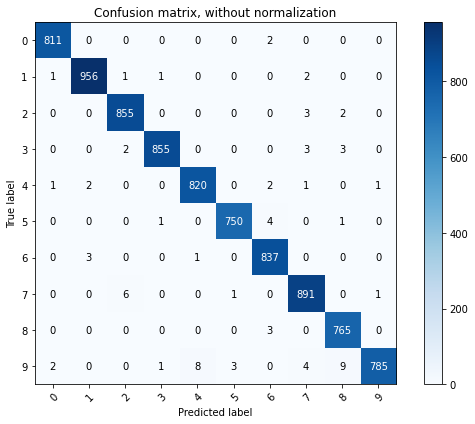

In [28]:
y_true = np.argmax(Y_val, axis=1)
X_val_img = X_val_img.astype('float')
y_pred = cnn_model.predict(X_val_img)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_true, y_pred, range(10), (8,6), False, 'Confusion Matrix')